In [2]:
pip install yfinance --upgrade --no-cache-dir

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def calculate_dcf(fcf, r, g, gp, years):
    """
    计算简化版的DCF模型。

    :param fcf: 当前的自由现金流（FCF）。
    :param r: 折现率。
    :param g: 利润增长率。
    :param g1: 永续利润增长率。
    :param years: 预测的年数（默认为5年）。
    :return: 计算得到的DCF值。
    """
    # 计算折现的自由现金流
    pv_fcf = 0
    for t in range(1, years + 1):
        fcf_t = fcf * ((1 + g) ** t)
        pv_fcf += fcf_t / ((1 + r) ** t)

    # 计算终值
    
    terminal_value = fcf * ((1 + g) ** years) * (1 + gp) / (r - gp)
    pv_terminal_value = terminal_value / ((1 + r) ** years)

    # 计算总的DCF值
    dcf_value = pv_fcf + pv_terminal_value

    return dcf_value



In [8]:
# 示例
fcf = 4  # 当前的自由现金流
r = 0.07    # 折现率（0.06-0.09）
g = 0.05    # 利润增长率
gp = 0.03  # 永续利润增长率
years = 5   # 预测的年数

dcf_value = calculate_dcf(fcf, r, g, gp, years)
print(f"简化版的DCF值: {dcf_value}")

简化版的DCF值: 112.63309067442154


In [19]:
# 加载财务数据
ticker = yf.Ticker("AAPL")  # 替换为目标公司代码
cashflow = ticker.cashflow  # 获取现金流数据
financials = ticker.financials
# 计算自由现金流（FCF）
#operating_cash_flow = cashflow.loc["Total Cash From Operating Activities"][0]
#capital_expenditures = cashflow.loc["Capital Expenditures"][0]
fcf = cashflow.loc["Free Cash Flow"][0]
print(f"自由现金流（FCF）: {fcf}")
Revenue_current = financials.loc["Total Revenue"][0]
Revenue_previous = financials.loc["Total Revenue"][1]
Revenue_growth_rate = ((Revenue_current - Revenue_previous) / Revenue_previous)
print(f"Revenue growth: {Revenue_growth_rate}")

自由现金流（FCF）: 108807000000.0
Revenue growth: 0.020219940775141214


C:\Users\602599140\AppData\Local\Temp\ipykernel_15828\1261653176.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fcf = cashflow.loc["Free Cash Flow"][0]
C:\Users\602599140\AppData\Local\Temp\ipykernel_15828\1261653176.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Revenue_current = financials.loc["Total Revenue"][0]
C:\Users\602599140\AppData\Local\Temp\ipykernel_15828\1261653176.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

In [21]:
def calculate_fcf_and_growth(ticker):
    """
    计算指定股票的 FCF 和利润增长率。
    """
    try:
        stock = yf.Ticker(ticker)
        
        # 获取现金流数据
        cashflow = stock.cashflow
        if cashflow.empty:
            return None, None
        
        # 计算 FCF（自由现金流）
        if "Free Cash Flow" in cashflow.index:
            fcf = cashflow.loc["Free Cash Flow"][0]
        else:
            fcf = None
        
        # 获取财务报表数据
        financials = stock.financials
        if financials.empty:
            return fcf, None
        
        # 计算利润增长率
        if "Total Revenue" in financials.index:
            Revenue = financials.loc["Total Revenue"]
            if len(Revenue) > 1:  # 确保至少有两年的数据
                growth_rate = (Revenue[0] - Revenue[1]) / abs(Revenue[1])
            else:
                growth_rate = None
        else:
            growth_rate = None
        
        return fcf, growth_rate
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        return None, None

In [25]:
spy = yf.Ticker("SPY")
constituents = spy.history(period="1d").index.tolist()[:5]  # 示例：获取前 100 个成分股
results = []
#fcf = 4  # 当前的自由现金流
r = 0.07    # 折现率（0.06-0.09）
#g = 0.05    # 利润增长率
gp = 0.03  # 永续利润增长率
years = 5   # 预测的年数
for ticker in constituents:
    print(f"Processing {ticker}...")
    fcf, growth_rate = calculate_fcf_and_growth(ticker)
    
    # 检查 FCF 和利润增长率是否有效
    if fcf is None or growth_rate is None:
        print(f"Skipping {ticker} due to missing data.")
        results.append({
            "Ticker": ticker,
            "FCF": fcf,
            "Growth Rate (%)": growth_rate,
            "DCF Value": None,
            "Market Cap": None
        })
        continue
    
    # 计算 DCF 值
    dcf_value = calculate_dcf(fcf, growth_rate)

    # 获取股票市值
    stock = yf.Ticker(ticker)
    info = stock.info
    market_cap = info.get("marketCap", None)
            # 保存结果
    results.append({
        "Ticker": ticker,
        "FCF": fcf,
        "Growth Rate ": growth_rate,
        "DCF Value": dcf_value,
        "Market Cap": market_cap
    })

# 转换为 DataFrame
df = pd.DataFrame(results)
df.head()
#df.to_csv("spy_analysis.csv", index=False)

Processing 2025-01-13 00:00:00-05:00...
Error processing 2025-01-13 00:00:00-05:00: 'Timestamp' object has no attribute 'upper'
Skipping 2025-01-13 00:00:00-05:00 due to missing data.


,Ticker,FCF,Growth Rate (%),DCF Value,Market Cap
0,2025-01-13 00:00:00-05:00,None,None,None,None


In [30]:

holdings = spy.info 
holdings


{'longBusinessSummary': 'The trust seeks to achieve its investment objective by holding a portfolio of the common stocks that are included in the index, with the weight of each stock in the portfolio substantially corresponding to the weight of such stock in the index.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 580.49,
 'open': 575.77,
 'dayLow': 575.35,
 'dayHigh': 578.61,
 'regularMarketPreviousClose': 580.49,
 'regularMarketOpen': 575.77,
 'regularMarketDayLow': 575.35,
 'regularMarketDayHigh': 578.61,
 'trailingPE': 26.681654,
 'volume': 9622900,
 'regularMarketVolume': 9622900,
 'averageVolume': 46684083,
 'averageVolume10days': 53635440,
 'averageDailyVolume10Day': 53635440,
 'bid': 577.29,
 'ask': 577.32,
 'bidSize': 1300,
 'askSize': 1300,
 'yield': 0.0121,
 'totalAssets': 623795240960,
 'fiftyTwoWeekLow': 469.87,
 'fiftyTwoWeekHigh': 609.07,
 'fiftyDayAverage': 593.7482,
 'twoHundredDayAverage': 556.0114,
 'trailingAnnualDividendRate': 5.662,
 'trailingAnnualDivide

In [25]:
# Define the ticker symbol and the time range
ticker_symbol = '^GSPC'  # S&P 500
start_date = '1950-01-01'
end_date = '2022-12-31'

# Download historical data
data = yf.download(ticker_symbol, start=start_date, end=end_date)



[*********************100%%**********************]  1 of 1 completed


In [26]:
# Calculate daily returns
data['Daily Returns'] = data['Adj Close'].pct_change()
# Resample the data to get monthly returns
data_monthly = data['Adj Close'].resample('ME').ffill().pct_change()
# Define U.S. Presidential Election years
election_years = ['1952-11-04', '1956-11-06', '1960-11-08', '1964-11-03', '1968-11-05',
                  '1972-11-07', '1976-11-02', '1980-11-04', '1984-11-06', '1988-11-08',
                  '1992-11-03', '1996-11-05', '2000-11-07', '2004-11-02', '2008-11-04',
                  '2012-11-06', '2016-11-08', '2020-11-03']

data.head(10)

,Open,High,Low,Close,Adj Close,Volume,Daily Returns
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,16.660000,1260000,NaN
1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000,0.011405
1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000,0.004748
1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000,0.002953
1950-01-09,17.080000,17.080000,17.080000,17.080000,17.080000,2520000,0.005889
1950-01-10,17.030001,17.030001,17.030001,17.030001,17.030001,2160000,-0.002927
1950-01-11,17.090000,17.090000,17.090000,17.090000,17.090000,2630000,0.003523
1950-01-12,16.760000,16.760000,16.760000,16.760000,16.760000,2970000,-0.019310
1950-01-13,16.670000,16.670000,16.670000,16.670000,16.670000,3330000,-0.005370


In [6]:
# Prepare a list to collect data for analysis
election_data = []

# Analyze data around election dates
for date in election_years:
    election_date = pd.to_datetime(date)
    window_start = election_date - pd.Timedelta(days=60)
    window_end = election_date + pd.Timedelta(days=60)
    
    # Extract the window data
    window_data = data.loc[window_start:window_end]
    
    # Calculate average return in the window
    avg_return = window_data['Daily Returns'].mean()
    
    # Append the data
    election_data.append({
        'Election Year': int(date[:4]),
        'Average Return': avg_return
    })

# Convert to DataFrame
election_df = pd.DataFrame(election_data)

# Calculate correlation
correlation = election_df['Election Year'].corr(election_df['Average Return'])

print(f"Correlation between election years and market returns: {correlation}")
print(election_df)

Correlation between election years and market returns: -0.12716104032154918
    Election Year  Average Return
0            1952        0.000641
1            1956       -0.000337
2            1960        0.000595
3            1964        0.000329
4            1968        0.000468
5            1972        0.001043
6            1976        0.000431
7            1980        0.001077
8            1984       -0.000118
9            1988        0.000679
10           1992        0.000523
11           1996        0.001726
12           2000       -0.001642
13           2004        0.000989
14           2008       -0.002577
15           2012        0.000324
16           2016        0.000539
17           2020        0.001081


In [13]:
# Analyze data around election dates
for date in election_years:
    election_date = pd.to_datetime(date)
    # Set window to four months before the election
    months = pd.date_range(start=election_date - pd.DateOffset(months=4), end=election_date, freq='M')
    
    # Get monthly returns for the window
    monthly_returns = data_monthly.loc[months].tolist()
    
    # Append the data
    election_data.append({
        'Election Year': date[:4],
        'Month -4': monthly_returns[0],
        'Month -3': monthly_returns[1],
        'Month -2': monthly_returns[2],
        'Month -1': monthly_returns[3]
    })

# Convert to DataFrame
election_df = pd.DataFrame(election_data)

print(election_df)

   Election Year  Month -4  Month -3  Month -2  Month -1
0           1952     1.76%    -1.46%    -1.96%    -0.08%
1           1956     5.15%    -3.81%    -4.55%     0.51%
2           1960    -2.48%     2.61%    -6.04%    -0.24%
3           1964     1.82%    -1.62%     2.87%     0.81%
4           1968    -1.85%     1.15%     3.85%     0.72%
5           1972     0.23%     3.45%    -0.49%     0.93%
6           1976    -0.81%    -0.51%     2.26%    -2.22%
7           1980     6.50%     0.58%     2.52%     1.60%
8           1984    -1.65%    10.63%    -0.35%    -0.01%
9           1988    -0.54%    -3.86%     3.97%     2.60%
10          1992     3.94%    -2.40%     0.91%     0.21%
11          1996    -4.57%     1.88%     5.42%     2.61%
12          2000    -1.63%     6.07%    -5.35%    -0.49%
13          2004    -3.43%     0.23%     0.94%     1.40%
14          2008    -0.99%     1.22%    -9.08%   -16.94%
15          2012     1.26%     1.98%     2.42%    -1.98%
16          2016     3.56%    -

C:\Users\602599140\AppData\Local\Temp\ipykernel_10076\1925595631.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start=election_date - pd.DateOffset(months=4), end=election_date, freq='M')


In [20]:
# Prepare a list to collect data for analysis
election_data = []

# Analyze data around election dates
for date in election_years:
    election_date = pd.to_datetime(date)
    # Set window to four months before the election
    months = pd.date_range(start=election_date - pd.DateOffset(months=4), end=election_date, freq='M')
    
    # Get monthly returns for the window
    monthly_returns = data_monthly.loc[months].tolist()
    
    # Append the data, converting returns to percentage format
    election_data.append({
        'Election Year': date[:4],
        'Month -4': f"{monthly_returns[0] * 100:.2f}%",
        'Month -3': f"{monthly_returns[1] * 100:.2f}%",
        'Month -2': f"{monthly_returns[2] * 100:.2f}%",
        'Month -1': f"{monthly_returns[3] * 100:.2f}%"
    })

# Convert to DataFrame
election_df = pd.DataFrame(election_data)

print(election_df)

   Election Year Month -4 Month -3 Month -2 Month -1
0           1952    1.76%   -1.46%   -1.96%   -0.08%
1           1956    5.15%   -3.81%   -4.55%    0.51%
2           1960   -2.48%    2.61%   -6.04%   -0.24%
3           1964    1.82%   -1.62%    2.87%    0.81%
4           1968   -1.85%    1.15%    3.85%    0.72%
5           1972    0.23%    3.45%   -0.49%    0.93%
6           1976   -0.81%   -0.51%    2.26%   -2.22%
7           1980    6.50%    0.58%    2.52%    1.60%
8           1984   -1.65%   10.63%   -0.35%   -0.01%
9           1988   -0.54%   -3.86%    3.97%    2.60%
10          1992    3.94%   -2.40%    0.91%    0.21%
11          1996   -4.57%    1.88%    5.42%    2.61%
12          2000   -1.63%    6.07%   -5.35%   -0.49%
13          2004   -3.43%    0.23%    0.94%    1.40%
14          2008   -0.99%    1.22%   -9.08%  -16.94%
15          2012    1.26%    1.98%    2.42%   -1.98%
16          2016    3.56%   -0.12%   -0.12%   -1.94%
17          2020    5.51%    7.01%   -3.92%   

C:\Users\602599140\AppData\Local\Temp\ipykernel_10076\2618338043.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start=election_date - pd.DateOffset(months=4), end=election_date, freq='M')


[*********************100%%**********************]  1 of 1 completed


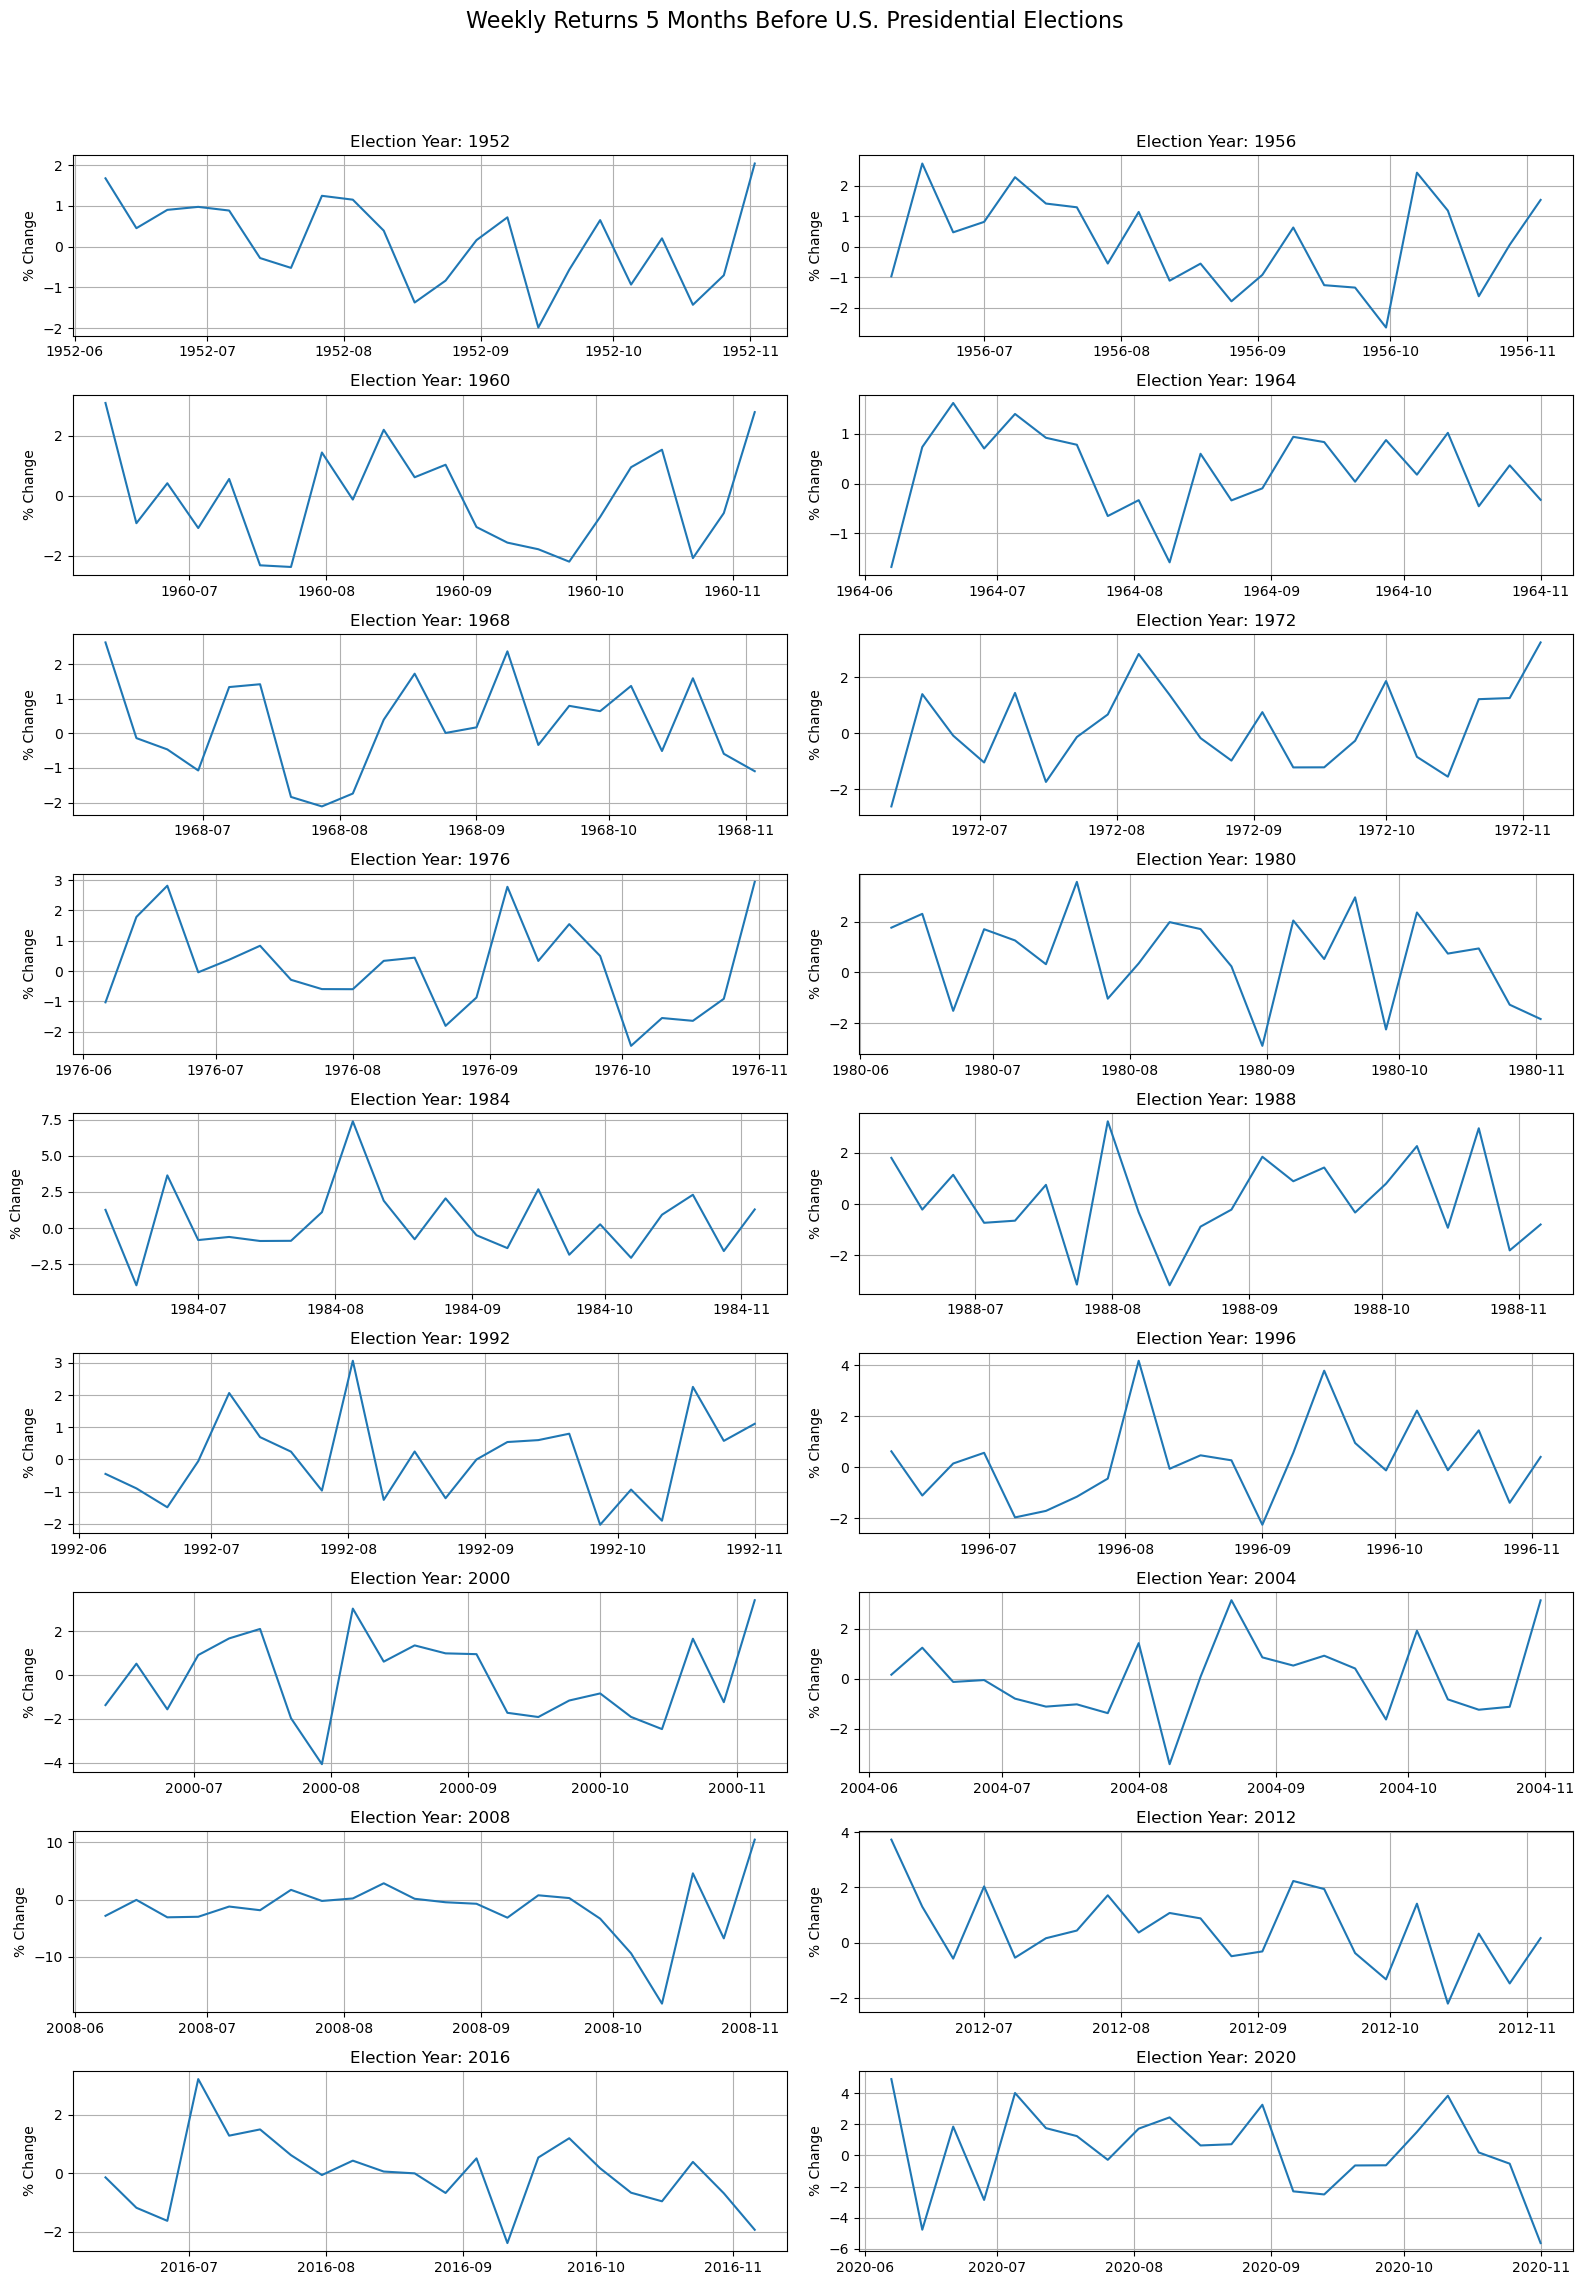

In [24]:
# Download historical data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Resample the data to get weekly returns
data_weekly = data['Adj Close'].resample('W').ffill().pct_change()

# Define U.S. Presidential Election years
election_years = ['1952-11-04', '1956-11-06', '1960-11-08', '1964-11-03', '1968-11-05',
                  '1972-11-07', '1976-11-02', '1980-11-04', '1984-11-06', '1988-11-08',
                  '1992-11-03', '1996-11-05', '2000-11-07', '2004-11-02', '2008-11-04',
                  '2012-11-06', '2016-11-08', '2020-11-03']

# Set up the plot
plt.figure(figsize=(16, 24))
plt.suptitle('Weekly Returns 5 Months Before U.S. Presidential Elections', fontsize=16)

# Plot weekly returns for each election year
for i, date in enumerate(election_years, 1):
    election_date = pd.to_datetime(date)
    start_date = election_date - pd.DateOffset(months=5)
    end_date = election_date
    
    # Get the weekly returns for the 5 months leading up to the election
    data_slice = data_weekly.loc[start_date:end_date]
    
    # Subplot for each election
    ax = plt.subplot(9, 2, i)
    ax.plot(data_slice.index, data_slice * 100)  # Convert to percentage
    ax.set_title(f'Election Year: {date[:4]}')
    ax.set_ylabel('% Change')
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [16]:
# Calculate the probability of at least one negative return
# Prepare to collect the data
results = []
for date in election_years:
    election_date = pd.to_datetime(date)
    start_date = election_date - pd.DateOffset(months=4)
    
    # Get monthly returns for the four months leading up to the election
    monthly_returns = data_monthly.loc[start_date:election_date - pd.DateOffset(days=1)]
    
    # Check if any of the months had a negative return
    has_negative = (monthly_returns < 0).any()
    
    # Append results
    results.append({
        'Election Year': date[:4],
        'Probability of a Decline': 'Yes' if has_negative else 'No'
    })

# Convert to DataFrame for display
results_df = pd.DataFrame(results)

# Count the occurrences of declines and calculate the probability
count_declines = sum(1 for result in results if result['Probability of a Decline'] == 'Yes')
total_elections = len(election_years)
probability_decline = count_declines / total_elections

print(f"Probability of at least one decline in the four months before the election: {probability_decline:.2f} or {probability_decline * 100:.2f}%")
print(results_df)

Probability of at least one decline in the four months before the election: 0.94 or 94.44%
   Election Year Probability of a Decline
0           1952                      Yes
1           1956                      Yes
2           1960                      Yes
3           1964                      Yes
4           1968                      Yes
5           1972                      Yes
6           1976                      Yes
7           1980                       No
8           1984                      Yes
9           1988                      Yes
10          1992                      Yes
11          1996                      Yes
12          2000                      Yes
13          2004                      Yes
14          2008                      Yes
15          2012                      Yes
16          2016                      Yes
17          2020                      Yes


In [30]:
# Prepare a list to collect data for analysis
election_data_post = []

# Analyze data around election dates
for date in election_years:
    election_date = pd.to_datetime(date)
    # Set window to four months before the election
    months = pd.date_range(start=election_date, end=election_date + pd.DateOffset(months=4), freq='M')
    
    # Get monthly returns for the window
    monthly_returns = data_monthly.loc[months].tolist()
    
    # Append the data, converting returns to percentage format
    election_data_post.append({
        'Election Year': date[:4],
        'Month 4': f"{monthly_returns[0] * 100:.2f}%",
        'Month 3': f"{monthly_returns[1] * 100:.2f}%",
        'Month 2': f"{monthly_returns[2] * 100:.2f}%",
        'Month 1': f"{monthly_returns[3] * 100:.2f}%"
    })

# Convert to DataFrame
election_df_post = pd.DataFrame(election_data_post)

print(election_df_post)

   Election Year Month 4 Month 3 Month 2  Month 1
0           1952   4.65%   3.55%  -0.72%   -1.82%
1           1956  -1.10%   3.53%  -4.18%   -3.26%
2           1960   4.03%   4.63%   6.32%    2.69%
3           1964  -0.52%   0.39%   3.32%   -0.15%
4           1968   4.80%  -4.16%  -0.82%   -4.74%
5           1972   4.56%   1.18%  -1.71%   -3.75%
6           1976  -0.78%   5.25%  -5.05%   -2.17%
7           1980  10.24%  -3.39%  -4.57%    1.33%
8           1984  -1.51%   2.24%   7.41%    0.86%
9           1988  -1.89%   1.47%   7.11%   -2.89%
10          1992   3.03%   1.01%   0.70%    1.05%
11          1996   7.34%  -2.15%   6.13%    0.59%
12          2000  -8.01%   0.41%   3.46%   -9.23%
13          2004   3.86%   3.25%  -2.53%    1.89%
14          2008  -7.48%   0.78%  -8.57%  -10.99%
15          2012   0.28%   0.71%   5.04%    1.11%
16          2016   3.42%   1.82%   1.79%    3.72%
17          2020  10.75%   3.71%  -1.11%    2.61%


C:\Users\602599140\AppData\Local\Temp\ipykernel_10076\679669974.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start=election_date, end=election_date + pd.DateOffset(months=4), freq='M')
